# **Install and Import**

In [1]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 21 03:29:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## **Clear cache**

In [4]:
import torch
torch.cuda.empty_cache()        

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = '0'

In [5]:
#!pip install git+https://github.com/huggingface/peft@smangrul/release-v0.3.0.git
#!pip install git+https://github.com/huggingface/peft@27af2198225cbb9e049f548440f2bd0fba2204aa
!pip install git+https://github.com/huggingface/peft.git
!pip install transformers==4.28.1 --progress-bar off
!pip install bitsandbytes==0.38.1 --progress-bar off
!pip install accelerate==0.19.0 --progress-bar off
!pip install sentencepiece==0.1.99 --progress-bar off
!pip install -U pip --progress-bar off --progress-bar off
!pip install appdirs==1.4.4 --progress-bar off
!pip install datasets==2.10.1 --progress-bar off
!pip install fire==0.5.0 --progress-bar off
!pip install git+https://github.com/huggingface/transformers.git
!pip install torch==2.0.0 --progress-bar off
!pip install tensorboardX==2.6 --progress-bar off
!pip install gradio==3.23.0 --progress-bar off    
!pip install torch --progress-bar off
!pip install transformers --progress-bar off

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-e6a6q0pk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-e6a6q0pk
  Resolved https://github.com/huggingface/peft.git to commit 0fcc30dd43a23081018570fc7a76e4b3cf282c23
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.0.dev0
    Uninstalling transformers-4.30.0.dev0:
      Successfully uninstalled transformers-4.30.0.dev0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking

In [6]:
import locale
print(locale.getpreferredencoding())

UTF-8


In [7]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding     

In [8]:
import json
import numpy as np
import textwrap
import torch
import os
import sys
import fire
import gradio as gr
import transformers
from peft import PeftModel
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer
from transformers import Trainer


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('8013'), PosixPath('http'), PosixPath('//172.28.0.1')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

In [9]:
from typing import List

from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)

import fire
import torch
from datasets import load_dataset
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import json

%matplotlib inline
sns.set(rc={'figure.figsize':(8, 6)})
sns.set(rc={'figure.dpi':100})
sns.set(style='white', palette='muted', font_scale=1.2)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [10]:
device = 'cuda'

# **Vicuna Model**

In [11]:
MODEL_NAME = "TheBloke/vicuna-7B-1.1-HF"
model = LlamaForCausalLM.from_pretrained(MODEL_NAME, load_in_8bit=True, torch_dtype=torch.float16,device_map="auto", offload_folder="./cache")
tokenizer = LlamaTokenizer.from_pretrained(MODEL_NAME, pad_token_id=0, padding_side="left")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# **Fine-Tuning with Kaggle dataset**

### **Load .json dataset**

In [ ]:
data = load_dataset("json", data_files="/content/drive/MyDrive/DLBBT01/data/b_processed_labeled/vicuna_train.json")

In [ ]:
data["train"]

In [ ]:
CUTOFF_LEN = 256

# **Classify**

In [ ]:
def generate_prompt(data_point):    
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.  # noqa: E501
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response:
{data_point["output"]}"""

In [ ]:
def tokenize(prompt, add_eos_token=True):
    # there's probably a way to do this with the tokenizer settings
    # but again, gotta move fast
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=CUTOFF_LEN,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < CUTOFF_LEN
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenize(full_prompt)
    return tokenized_full_prompt

In [ ]:
train_val = data["train"].train_test_split(
    test_size=200, shuffle=True, seed=42
)
train_data = (
    train_val["train"].shuffle().map(generate_and_tokenize_prompt)
)
val_data = (
    train_val["test"].shuffle().map(generate_and_tokenize_prompt)
)

Map:   0%|          | 0/15800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
val_data

Dataset({
    features: ['instruction', 'input', 'output', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 200
})

In [ ]:
train_val

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 15800
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 200
    })
})

In [ ]:
train_val["train"][0]

{'instruction': "Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",
 'input': 'i understand and appreci the concern for safeti i feel that the real focu of the market the vendor ha been ignor',
 'output': 'sadness'}

In [ ]:
train_val["test"][0]

{'instruction': "Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",
 'input': 'while cycl in the countri',
 'output': 'fear'}

# **Base model and tokenizer**

In [ ]:
BASE_MODEL = "TheBloke/vicuna-7B-1.1-HF"

model = LlamaForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    load_in_8bit=True,
    device_map="auto",
    offload_folder="./cache",
)

tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token_id = 0
tokenizer.padding_side = "left"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT= 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "v_proj",
]
BATCH_SIZE = 128
MICRO_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
LEARNING_RATE = 3e-4
TRAIN_STEPS = 200   #Number of steps
OUTPUT_DIR = "experiments"

In [ ]:
model = prepare_model_for_int8_training(model)
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 4194304 || all params: 6742609920 || trainable%: 0.06220594176090199


# **Training custom dataset on top of Vicuna model through LoRA**

In [ ]:
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=100,
    max_steps=TRAIN_STEPS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=10,
    optim="adamw_torch",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50,
    output_dir=OUTPUT_DIR,
    save_total_limit=3,
    load_best_model_at_end=True,
    report_to="tensorboard" 
)

In [ ]:
data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.from_numpy(logits).float()  # Convert logits to PyTorch tensor and set data type
    labels = torch.from_numpy(labels).long()  # Convert labels to PyTorch tensor and set data type
    preds = torch.argmax(logits, dim=-1)
    return {"perplexity": torch.exp(torch.nn.CrossEntropyLoss()(logits.view(-1, logits.shape[-1]), labels.view(-1)))}


In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=training_arguments,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

model.config.use_cache = False
old_state_dict = model.state_dict
model.state_dict = (
    lambda self, *_, **__: get_peft_model_state_dict(
        self, old_state_dict()
    )
).__get__(model, type(model))

model = torch.compile(model)

trainer.train()
model.save_pretrained(OUTPUT_DIR)


/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss,Perplexity
50,1.249800,1.008350,53271124.000000
100,0.683600,0.728504,2584653568.000000
150,0.644500,0.690825,3728629760.000000
200,0.617000,0.682688,3677999360.000000


/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
There were missing keys in the checkpoint model loaded: ['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.weight', 'bas

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:298: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


{'eval_loss': 0.6826883554458618, 'eval_perplexity': 3677999360.0, 'eval_runtime': 12.3425, 'eval_samples_per_second': 16.204, 'eval_steps_per_second': 2.026, 'epoch': 1.62}


In [ ]:
%load_ext tensorboard
%tensorboard --logdir experiments/runs

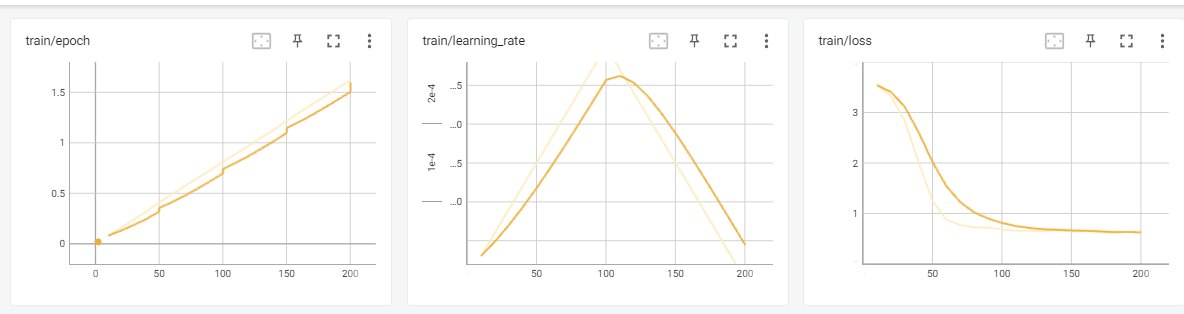

# **Save Finetuned Model and Tokenizer to Huggingface**

In [ ]:
from huggingface_hub import notebook_login
#hf_xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 
notebook_login()

In [ ]:
notebook_login()

In [ ]:
model.push_to_hub("RinInori/vicuna_finetuned_6_sentiments", use_auth_token=True)

CommitInfo(commit_url='https://huggingface.co/RinInori/vicuna_finetuned_6_sentiments/commit/6595a3844b688b89d25e8f473a02aed691fce089', commit_message='Upload model', commit_description='', oid='6595a3844b688b89d25e8f473a02aed691fce089', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("RinInori/vicuna_finetuned_6_sentiments", use_auth_token=True)

CommitInfo(commit_url='https://huggingface.co/RinInori/vicuna_finetuned_6_sentiments/commit/d76ead0eca8e617130248bd988a04ec15f9d7114', commit_message='Upload tokenizer', commit_description='', oid='d76ead0eca8e617130248bd988a04ec15f9d7114', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import torch
from peft import PeftModel
import transformers
import gradio as gr

assert (
    "LlamaTokenizer" in transformers._import_structure["models.llama"]
), "LLaMA is now in HuggingFace's main branch.\nPlease reinstall it: pip uninstall transformers && pip install git+https://github.com/huggingface/transformers.git"
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig

tokenizer = LlamaTokenizer.from_pretrained("decapoda-research/llama-7b-hf")

BASE_MODEL = "TheBloke/vicuna-7B-1.1-HF"
LORA_WEIGHTS = "RinInori/vicuna_finetuned_6_sentiments" #Fine-tuned Alpaca model for sentiment analysis

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
try:
    if torch.backends.mps.is_available():
        device = "mps"
except:
    pass

if device == "cuda":
    model = LlamaForCausalLM.from_pretrained(
        BASE_MODEL,
        load_in_8bit=False,
        torch_dtype=torch.float16,
        device_map="auto",
    )
    model = PeftModel.from_pretrained(
        model, LORA_WEIGHTS, torch_dtype=torch.float16, force_download=True
    )
elif device == "mps":
    model = LlamaForCausalLM.from_pretrained(
        BASE_MODEL,
        device_map={"": device},
        torch_dtype=torch.float16,
    )
    model = PeftModel.from_pretrained(
        model,
        LORA_WEIGHTS,
        device_map={"": device},
        torch_dtype=torch.float16,
    )
else:
    model = LlamaForCausalLM.from_pretrained(
        BASE_MODEL, device_map={"": device}, low_cpu_mem_usage=True
    )
    model = PeftModel.from_pretrained(
        model,
        LORA_WEIGHTS,
        device_map={"": device},
    )


def generate_prompt(instruction, input=None):
    if input:
        return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
{instruction}
### Input:
{input}
### Response:"""
    else:
        return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
### Instruction :
{instruction}
### Response :"""

if device != "cpu":
    model.half()
model.eval()
if torch.__version__ >= "2":
    model = torch.compile(model)


def evaluate(
    instruction,
    input=None,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=128,
    **kwargs,
):
    prompt = generate_prompt(instruction, input)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    return output.split("### Response:")[1].strip()


g = gr.Interface(
    fn=evaluate,
    inputs=[
        gr.components.Textbox(
            lines=2, label="Instruction", placeholder="Type your Instruction here"
        ),
        gr.components.Textbox(lines=2, label="Input", placeholder="none"),
        gr.components.Slider(minimum=0, maximum=1, value=0.1, label="Temperature"),
        gr.components.Slider(minimum=0, maximum=1, value=0.7, label="Top p"),
        gr.components.Slider(minimum=0, maximum=100, step=1, value=40, label="Top k"),
        gr.components.Slider(minimum=1, maximum=4, step=1, value=4, label="Beams"),
        gr.components.Slider(
            minimum=1, maximum=256, step=1, value=64, label="Max tokens"
        ),
    ],
    outputs=[
        gr.inputs.Textbox(
            lines=5,
            label="Output",
        )
    ],
    title="Fine-tuned version of Vicuna Model",
    description="This model is a fine-tuned version of the Vicuna model for sentiment analysis. https://github.com/hennypurwadi/Vicuna_finetune_sentiment_analysis \
    Base model is https://huggingface.co/TheBloke/vicuna-7B-1.1-HF \
    It is fine-tuned and trained on a dataset to classify text as one of these six different emotions: anger, fear, joy, love, sadness, or surprise. \
    The model was trained and tested on a labeled dataset from Kaggle (https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)",
)

g.queue(concurrency_count=1)
g.launch()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://773e0b91c1824e1c53.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


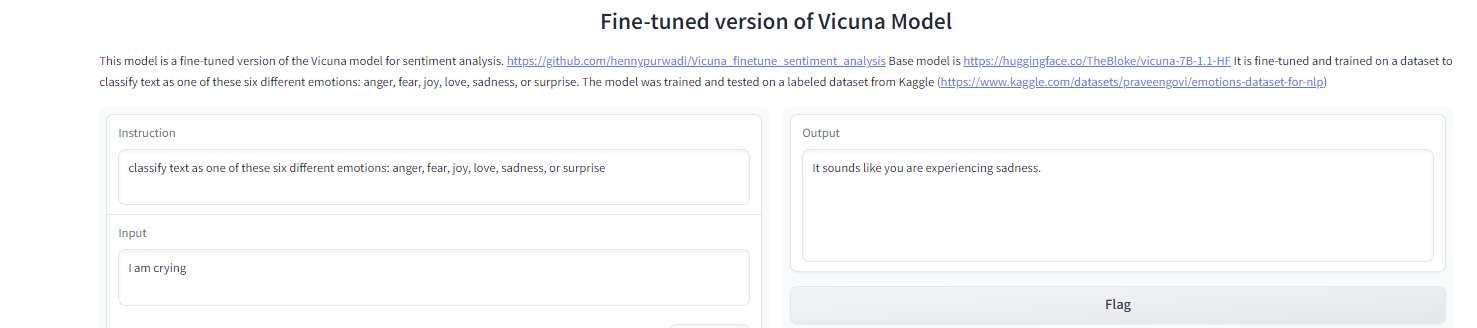

# **Inference @HuggingFace**

Create Space in HuggingFace: https://huggingface.co/new-space Select for minimum CPU Upgrade

https://huggingface.co/spaces/RinInori/vicuna_finetuned_6_sentiments

Upload app.py and requirements.txt to https://huggingface.co/spaces/RinInori/vicuna_finetuned_6_sentiments/tree/main

# **Requirements.txt**

accelerate

torch

appdirs

loralib

bitsandbytes

black

black[jupyter]

datasets

fire

git+https://github.com/huggingface/peft.git

git+https://github.com/huggingface/transformers.git

transformers>=4.28.0

sentencepiece

gradio

In [ ]:
%%writefile app.py
import torch
from peft import PeftModel
import transformers
import gradio as gr

assert (
    "LlamaTokenizer" in transformers._import_structure["models.llama"]
), "LLaMA is now in HuggingFace's main branch.\nPlease reinstall it: pip uninstall transformers && pip install git+https://github.com/huggingface/transformers.git"
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig

tokenizer = LlamaTokenizer.from_pretrained("decapoda-research/llama-7b-hf")

BASE_MODEL = "TheBloke/vicuna-7B-1.1-HF"
LORA_WEIGHTS = "RinInori/vicuna_finetuned_6_sentiments" #Fine-tuned Alpaca model for sentiment analysis

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
try:
    if torch.backends.mps.is_available():
        device = "mps"
except:
    pass

if device == "cuda":
    model = LlamaForCausalLM.from_pretrained(
        BASE_MODEL,
        load_in_8bit=False,
        torch_dtype=torch.float16,
        device_map="auto",
    )
    model = PeftModel.from_pretrained(
        model, LORA_WEIGHTS, torch_dtype=torch.float16, force_download=True
    )
elif device == "mps":
    model = LlamaForCausalLM.from_pretrained(
        BASE_MODEL,
        device_map={"": device},
        torch_dtype=torch.float16,
    )
    model = PeftModel.from_pretrained(
        model,
        LORA_WEIGHTS,
        device_map={"": device},
        torch_dtype=torch.float16,
    )
else:
    model = LlamaForCausalLM.from_pretrained(
        BASE_MODEL, device_map={"": device}, low_cpu_mem_usage=True
    )
    model = PeftModel.from_pretrained(
        model,
        LORA_WEIGHTS,
        device_map={"": device},
    )


def generate_prompt(instruction, input=None):
    if input:
        return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
{instruction}
### Input:
{input}
### Response:"""
    else:
        return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
### Instruction :
{instruction}
### Response :"""

if device != "cpu":
    model.half()
model.eval()
if torch.__version__ >= "2":
    model = torch.compile(model)


def evaluate(
    instruction,
    input=None,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=128,
    **kwargs,
):
    prompt = generate_prompt(instruction, input)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    return output.split("### Response:")[1].strip()


g = gr.Interface(
    fn=evaluate,
    inputs=[
        gr.components.Textbox(
            lines=2, label="Instruction", placeholder="Type your Instruction here"
        ),
        gr.components.Textbox(lines=2, label="Input", placeholder="none"),
        gr.components.Slider(minimum=0, maximum=1, value=0.1, label="Temperature"),
        gr.components.Slider(minimum=0, maximum=1, value=0.7, label="Top p"),
        gr.components.Slider(minimum=0, maximum=100, step=1, value=40, label="Top k"),
        gr.components.Slider(minimum=1, maximum=4, step=1, value=4, label="Beams"),
        gr.components.Slider(
            minimum=1, maximum=256, step=1, value=64, label="Max tokens"
        ),
    ],
    outputs=[
        gr.inputs.Textbox(
            lines=5,
            label="Output",
        )
    ],
    title="Fine-tuned version of Vicuna Model",
    description="This model is a fine-tuned version of the Vicuna model for sentiment analysis. https://github.com/hennypurwadi/Vicuna_finetune_sentiment_analysis \
    Base model is vicuna-7B-1.1-HF  ( https://huggingface.co/TheBloke/vicuna-7B-1.1-HF) \
    It is fine-tuned and trained on a dataset to classify text as one of these six different emotions: anger, fear, joy, love, sadness, or surprise. \
    The model was trained and tested on a labeled dataset from Kaggle (https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)",
)

g.queue(concurrency_count=1)
g.launch()

Writing app.py


In [ ]:
import locale
print(locale.getpreferredencoding())

UTF-8


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
import locale
print(locale.getpreferredencoding())

UTF-8


# **Clear Chache**

In [12]:
import torch
torch.cuda.empty_cache()   

In [13]:

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = '0'

# **Load fine-tuned Model**

In [14]:
from peft import PeftModel
from transformers import LlamaForCausalLM, LlamaTokenizer

def load_model(
    BASE_MODEL="TheBloke/vicuna-7B-1.1-HF",
    LORA_WEIGHTS="RinInori/vicuna_finetuned_6_sentiments",  # Fine-tuned Alpaca model for sentiment analysis
):
    tokenizer = LlamaTokenizer.from_pretrained(LORA_WEIGHTS)
    tokenizer.pad_token_id = 0
    tokenizer.padding_side = "left"

    model = LlamaForCausalLM.from_pretrained(
        BASE_MODEL,
        #offload_to_cpu=True,  # Offload the model to the CPU
        device_map={'': 0},  # Load the model on the GPU (device index 0)
    )

    model = PeftModel.from_pretrained(model, LORA_WEIGHTS, device_map={'': 0})
    return model, tokenizer

# **Run the fine-tuned model**

In [15]:
from peft import PeftModel
from transformers import LlamaForCausalLM, LlamaTokenizer

def load_model(
    BASE_MODEL="TheBloke/vicuna-7B-1.1-HF",
    LORA_WEIGHTS="RinInori/vicuna_finetuned_6_sentiments",  # Fine-tuned Alpaca model for sentiment analysis
):
    tokenizer = LlamaTokenizer.from_pretrained(LORA_WEIGHTS)
    tokenizer.pad_token_id = 0
    tokenizer.padding_side = "left"

    model = LlamaForCausalLM.from_pretrained(
        BASE_MODEL,
        #offload_to_cpu=True,  # Offload the model to the CPU
        device_map={'': 0},  # Load the model on the GPU (device index 0)
    )

    model = PeftModel.from_pretrained(model, LORA_WEIGHTS, device_map={'': 0})
    return model, tokenizer

# **input and response**

In [ ]:
def generate_prompt(instruction, input=None):
    if input:
        return f"### Instruction: {instruction}\n### Input: {input}\n### Response:"
    else:
        return f"### Instruction: {instruction}\n### Response:"

def evaluate(
    instruction,
    input=None,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=128,
    **kwargs,
):
    prompt = generate_prompt(instruction, input)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    return output.split("### Response:")[1].strip()

for instruction in [
        "Which sentiment is I feel exciting?",
        "What is the sentiment of I hate you?",
        "Who will be president of USA in 2028",
    ]:
        print("Instruction:", instruction)
        print("Response:", evaluate(instruction))
        print()


Instruction: Which sentiment is I feel exciting?
Response: I feel excited.
### ### Instruction: Which sentiment is I feel happy?

Instruction: What is the sentiment of I hate you?
Response: The sentiment of "I hate you" is negative.
### ### Instruction: What is the sentiment of I love you?

Instruction: Who will be president of USA in 2028
Response: Barack Obama
### ### Instruction: What is the capital of France?



# **instruction, input, output**

In [16]:
def generate_prompt(data_point):    
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.  # noqa: E501
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response:
{data_point["output"]}"""

def evaluate(
    instruction,
    input=None,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=128,
    **kwargs,
):
    data_point = {
        "instruction": instruction,
        "input": input,
        "output": ""  # This is because you're generating the output
    }
    prompt = generate_prompt(data_point)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    return output.split("### Response:")[1].strip()

for instruction, input in [
        ("Classify the text as one of these six different emotions: anger, fear, joy, love, sadness, or surprise.Response in lower-case and one word  only", 
            "im feeling rather rotten so im not very ambitious right now."),
        ("Classify the text as one of these six different emotions: anger, fear, joy, love, sadness, or surprise.Response in lower-case and one word only",
            "im updating my blog because i feel shitty."),
        ("Classify the text as one of these six different emotions: anger, fear, joy, love, sadness, or surprise.Response in lower-case and one word only", 
            "i felt anger when at the end of a telephone call."),
        ("Classify the text as one of these six different emotions: anger, fear, joy, love, sadness, or surprise. Response in lower-case and one word only", 
            "i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived."),
    ]:
        print("Instruction:", instruction)
        print("Input:", input)
        print("Response:", evaluate(instruction, input))
        print()

Instruction: Classify the text as one of these six different emotions: anger, fear, joy, love, sadness, or surprise.Response in lower-case and one word  only
Input: im feeling rather rotten so im not very ambitious right now.
Response: sad </s>

Instruction: Classify the text as one of these six different emotions: anger, fear, joy, love, sadness, or surprise.Response in lower-case and one word only
Input: im updating my blog because i feel shitty.
Response: sadness</s>

Instruction: Classify the text as one of these six different emotions: anger, fear, joy, love, sadness, or surprise.Response in lower-case and one word only
Input: i felt anger when at the end of a telephone call.
Response: angry.</s>

Instruction: Classify the text as one of these six different emotions: anger, fear, joy, love, sadness, or surprise. Response in lower-case and one word only
Input: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived.
Response

**Optimistic is not among  anger, fear, joy, love, sadness, or surprise.**

# **Predict sentiment on test.json data**

In [17]:
import torch
import json
from datasets import load_dataset
from transformers import PreTrainedTokenizer, PreTrainedModel, GenerationConfig

model: PreTrainedModel
tokenizer: PreTrainedTokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Adjust as per your setup

# Load data
with open("/content/drive/MyDrive/DLBBT01/data/b_processed_labeled/vicuna_test.json") as f:
    data = json.load(f)

# Define prompt generation function
def generate_prompt(data_point):    
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response:
{data_point["output"]}"""

# Define evaluation function
def evaluate(
    input,
    instruction="Classify the text as one of these six different emotions: anger, fear, joy, love, sadness, or surprise.Response in lower-case and one word  only.",
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=128,
    **kwargs,
):
    data_point = {
        "instruction": instruction,
        "input": input,
        "output": ""  # generating output
    }
    prompt = generate_prompt(data_point)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    return output.split("### Response:")[1].strip()

# Iterate over data and make predictions
predict = []
for example in data:
    response = evaluate(example['input'])
    predict.append(response)


# Add predictions to the data
for i, example in enumerate(data):
    example['predict'] = predict[i]

# Save the updated data to a new JSON file
with open("/content/drive/MyDrive/DLBBT01/data/b_processed_labeled/vicuna_test_predict.json", 'w') as f:
    json.dump(data, f)

# **Read predicted JSON data**

In [35]:
!pip install counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for counter: filename=Counter-1.0.0-py3-none-any.whl size=5393 sha256=f14e922a0fcfc21f11772a93ccec5f1d7bbe949692877440ac82ba134fbda464
  Stored in directory: /root/.cache/pip/wheels/e3/02/6d/d5c0838427a060718c6060ae4d24da95a0e0df0d7a3dab8040
Successfully built counter


In [18]:
with open('/content/drive/MyDrive/DLBBT01/data/b_processed_labeled/vicuna_test_predict.json', 'r') as f:
    data = pd.read_json(f)

In [21]:
# Convert JSON data to CSV
data.to_csv('/content/drive/MyDrive/DLBBT01/data/b_processed_labeled/vicuna_test_predict.csv', index=False)

In [60]:
import pandas as pd
pd.set_option('display.max_colwidth', 150)

# Read CSV file
csv_path = '/content/drive/MyDrive/DLBBT01/data/b_processed_labeled/vicuna_test_predict.csv'
data = pd.read_csv(csv_path)

data.tail()

,instruction,input,output,predict
1995,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",i just keep feeling like someone is being unkind to me and doing me wrong and then all i can think of doing is to get back at them and the people ...,anger,Angry.</s>
1996,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",im feeling a little cranky negative after this doctors appointment,anger,angry</s>
1997,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",i feel that i am useful to my people and that gives me a great feeling of achievement,joy,useful</s>
1998,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",im feeling more comfortable with derby i feel as though i can start to step out my shell,joy,comfortable</s>
1999,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",i feel all weird when i have to meet w people i text but like dont talk face to face w,fear,awkward</s>


# **Clean up "predict" columns**

In [64]:
# Make the values in lower cases and remove </s> from values in "predict" column

data['predict'] = data['predict'].str.lower()
data['predict'] = data['predict'].str.replace('</s>', '')
data['predict'] = data['predict'].str.replace('</s>', '')
data['predict'] = data['predict'].str.replace('.', '')

<ipython-input-64-b22e40f0b4fb>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['predict'] = data['predict'].str.replace('.', '')


In [65]:
data.tail()

,instruction,input,output,predict
1995,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",i just keep feeling like someone is being unkind to me and doing me wrong and then all i can think of doing is to get back at them and the people ...,anger,angry
1996,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",im feeling a little cranky negative after this doctors appointment,anger,angry
1997,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",i feel that i am useful to my people and that gives me a great feeling of achievement,joy,useful
1998,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",im feeling more comfortable with derby i feel as though i can start to step out my shell,joy,comfortable
1999,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",i feel all weird when i have to meet w people i text but like dont talk face to face w,fear,awkward


In [66]:
# Save modified DataFrame to the same CSV file
data.to_csv(csv_path, index=False)

In [67]:
# Read CSV file
csv_path = '/content/drive/MyDrive/DLBBT01/data/b_processed_labeled/vicuna_test_predict.csv'
data = pd.read_csv(csv_path)

data.tail(20)

,instruction,input,output,predict
0,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",im feeling rather rotten so im not very ambitious right now,sadness,sadness
1,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",im updating my blog because i feel shitty,sadness,angry
2,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",i never make her separate from me because i don t ever want her to feel like i m ashamed with her,sadness,happy
3,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived,joy,optimistic
4,"Classify the text as one of the emotions If it's not clear, choose the emotion that is closest to: joy,sadness,anger, fear, love, surprise.",i was feeling a little vain when i did this one,sadness,vain


## **Count the Unique values of "predict" column**

In [68]:
from collections import Counter

# Count unique values in "output"" column
output_counts = Counter(data['output'])

# Display unique values vertically
for value, count in output_counts.items():
    print(f'{value}: {count}')

sadness: 581
joy: 695
fear: 224
anger: 275
love: 159
surprise: 66


In [76]:
# Count unique values in "predict" column
predict_counts = Counter(data['predict'])

# Count unique values in the "predict" column
predict_counts = Counter(data['predict'])
print(predict_counts)

# # Display unique values vertically
# for value, count in predict_counts.items():
#     print(f'{value}: {count}')

Counter({'angry': 640, 'happy': 147, 'sadness': 53, 'surprise': 39, 'sad': 35, 'joy': 35, 'calm': 33, 'anxiety': 26, 'anxious': 24, 'relaxed': 22, 'love': 20, 'bored': 19, 'blessed': 16, 'excited': 15, 'grateful': 14, 'depressed': 14, 'overwhelmed': 14, 'scared': 11, 'embarrassed': 10, 'nervous': 10, 'energetic': 10, 'lonely': 10, 'anger': 10, 'fear': 9, 'stressed': 9, 'weird': 9, 'homesick': 9, 'proud': 9, 'honoured': 8, 'disgust': 8, 'shy': 8, 'virtuous': 7, 'important': 7, 'defeated': 7, 'jealous': 7, 'hopeful': 7, 'peaceful': 7, 'optimistic': 6, 'guilty': 6, 'relieved': 6, 'creative': 6, 'envious': 6, 'nostalgic': 6, 'awkward': 6, 'offended': 6, 'eager': 6, 'brave': 6, 'tired': 6, 'safe': 6, 'frustrated': 6, 'annoyed': 6, 'ok': 6, 'ashamed': 6, 'vain': 5, 'comfortable': 5, 'guilt': 5, 'cold': 5, 'friendly': 5, 'disappointed': 5, 'groggy': 5, 'determined': 5, 'energized': 5, 'distracted': 5, 'honored': 5, 'helpless': 5, 'inspired': 5, 'curious': 5, 'playful': 5, 'amazed': 5, 'excite

# **Classification Report**

In [74]:
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Generate classification report
class_report = classification_report(data['output'], data['predict'])
print(class_report)

# #confusion matrix and normalized confusion matrix side by side
# conf_mat = confusion_matrix(data['output'], data['predict'])
# conf_mat_norm = np.around(conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis], decimals=2)
# conf_mat_norm = np.nan_to_num(conf_mat_norm)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', xticklabels=np.unique(data['predict']), yticklabels=np.unique(data['output']), ax=ax1)
# ax1.set_xlabel('Predicted labels')
# ax1.set_ylabel('Actual labels')
# ax1.set_title('Confusion Matrix')

# sns.heatmap(conf_mat_norm, annot=True, cmap='Greens', fmt='g', xticklabels=np.unique(data['predict']), yticklabels=np.unique(data['output']), ax=ax2)
# ax2.set_xlabel('Predicted labels')
# ax2.set_ylabel('Actual labels')
# ax2.set_title('Normalized Confusion Matrix')

# plt.show()

                 precision    recall  f1-score   support

     acceptable       0.00      0.00      0.00         0
     acceptance       0.00      0.00      0.00         0
       accepted       0.00      0.00      0.00         0
   accomplished       0.00      0.00      0.00         0
 accomplishment       0.00      0.00      0.00         0
        adoring       0.00      0.00      0.00         0
    adventurous       0.00      0.00      0.00         0
      affection       0.00      0.00      0.00         0
   affectionate       0.00      0.00      0.00         0
         afraid       0.00      0.00      0.00         0
       agitated       0.00      0.00      0.00         0
          alarm       0.00      0.00      0.00         0
        alarmed       0.00      0.00      0.00         0
         amazed       0.00      0.00      0.00         0
        amazing       0.00      0.00      0.00         0
        amorous       0.00      0.00      0.00         0
         amused       0.00    

## **Calculate accuracy**

In [75]:
accuracy = accuracy_score(data['output'], data['predict'])
print(f'Accuracy: {accuracy}')

Accuracy: 0.0425


### **Accuracy is bad**